In [1]:
from Step1_Processing_Energy_Generation_Data import *
from Step2_Processing_Price_Data import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels
from sklearn import metrics
from IPython.display import display


C:\Users\Samsung\Desktop\General_Assembly\Project\GA_Project_HH\Step2_Processing_Price_Data.py:62: DtypeWarning: Columns (1,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,29,34,36,37,41,43,44,45,46,48,50,56,57,60) have mixed types. Specify dtype option on import or set low_memory=False.
  p2000 = pd.read_csv('./Data-CSV/Price2000.csv', encoding = 'latin1')
C:\Users\Samsung\Desktop\General_Assembly\Project\GA_Project_HH\Step2_Processing_Price_Data.py:68: DtypeWarning: Columns (1,2,4,5,8,9,12,15,19,21,22,23,26,27,29,31,33,36,37,38,40,46,48,49,51,54,55,58,61,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  p1994 = pd.read_csv('./Data-CSV/Price1994.csv', encoding = 'latin1')
C:\Users\Samsung\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
def Energy_Price_Impact_Tool():
# Combining energy source percentage data, pricing data, and generation data so each is readily accessible in one df
    combined = {}
    for state in state_list:
        combined[state] = pd.concat([state_mix[state], state_pricing[state], state_gen[state]], axis = 1)
        combined[state].dropna(inplace = True)
        combined[state].columns.name = state
# Allows user to input state    
    state = str(input("Enter your abbreviated state name or US for national data: "))
    state = state.upper()
# Allows user to input their consumer type   
    consumer_type = str(input("Enter your consumer type, type R for Residential, C for Commercial, I for Industrial: "))
    consumer_type = consumer_type.upper()
    
    if consumer_type == 'R':
        consumer_type = 'Residential'
        consumer_type_real = 'Residential_adj'
    elif consumer_type == 'C':
        consumer_type = 'Commercial'
        consumer_type_real = 'Commercial_adj'        
    elif consumer_type == 'I':
        consumer_type = 'Industrial'
        consumer_type_real = 'Industrial_adj'
    elif consumer_type != 'R' or consumer_type != 'C' or consumer_type != 'I':
        return print('Error: Consumer type entered incorrectly, please restart')
        
# Allows user to choose independent variables set, either energy sources as a % of total net generation or generation in MWh    
    independent_vars_selection = str(input("Enter your predictive factor type, P for Percentage of Energy Source mix, or G for Generation in MWh: "))
    independent_vars_selection = independent_vars_selection.upper()
    
    if independent_vars_selection == 'P':
        visual = combined[state][[consumer_type,'Core_CPI', consumer_type_real, 'Renewables_pct','Fossil_Fuels_pct','Nuclear_pct', 'Pumped_Storage_pct', 'Other_pct']]
        display(visual)
        independent_vars = ['Renewables_pct', 'Fossil_Fuels_pct', 'Nuclear_pct', 'Core_CPI']
        # Create the bar plots
        plt.figure(figsize=(10,5)) 
        plt.plot(combined[state][independent_vars[0]],  label=independent_vars[0], linewidth = '4')
        plt.plot(combined[state][independent_vars[1]],  label=independent_vars[1], linewidth = '4')
        plt.plot(combined[state][independent_vars[2]], label=independent_vars[2], linewidth = '4')
        ax = plt.gca()   
        # Add x-axis and y-axis labels and a title
        plt.xlabel('Year')
        plt.ylabel('Percent of all Energy Generation')
        plt.title('Energy Source Share Change Since 1994')
        n = 2  # Keeps every nth label
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
        # Add legend
        plt.legend()
        # Show the chart
        plt.show()
    
    elif independent_vars_selection == 'G':
        visual = combined[state][[consumer_type, 'Core_CPI', consumer_type_real, 'Coal', 'Geothermal', 'Hydroelectric Conventional', 'Natural Gas','Nuclear', 'Other', 'Other Biomass', 'Other Gases', 'Petroleum','Pumped Storage', 'Solar Thermal and Photovoltaic', 'Wind','Wood and Wood Derived Fuels', 'Total']]
        display(visual)
        independent_vars = ['Coal','Hydroelectric Conventional','Natural Gas','Nuclear','Petroleum','Solar Thermal and Photovoltaic','Wind','Core_CPI']
        # Create the bar plots
        plt.figure(figsize=(10,5)) 
        plt.plot(combined[state][independent_vars[0]],  label=independent_vars[0], linewidth = '4')
        plt.plot(combined[state][independent_vars[1]],  label=independent_vars[1], linewidth = '4')
        plt.plot(combined[state][independent_vars[2]], label=independent_vars[2], linewidth = '4')
        plt.plot(combined[state][independent_vars[3]], label=independent_vars[3], linewidth = '4')
        plt.plot(combined[state][independent_vars[4]], label=independent_vars[4], linewidth = '4')
        plt.plot(combined[state][independent_vars[5]], label=independent_vars[5], linewidth = '4')
        plt.plot(combined[state][independent_vars[6]], label=independent_vars[6], linewidth = '4')
        ax = plt.gca()   
        # Add x-axis and y-axis labels and a title
        plt.xlabel('Year')
        plt.ylabel('Generation in MWh')
        plt.title('Energy Source Generation Change Since 1994')
        n = 2  # Keeps every nth label
        [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
        # Add legend
        plt.legend()
        # Show the chart
        plt.show()
        
    elif independent_vars_selection != 'P' or independent_vars_selection != 'G':
        return print('Error: Predictive factor type entered incorrectly, please restart')
# Runs the multivriate regression 1000 times and then takes mean values for r2, MAE, MSE, and RMSE    
    def montecarlo(df):
        global X
        global Y
        X = combined[state][independent_vars]#.values
        y = combined[state][consumer_type]#.values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
        global mlr 
        mlr = LinearRegression()  
        mlr.fit(X_train, y_train)
        global y_pred_mlr
        y_pred_mlr= mlr.predict(X_test)
        rsquare = round(mlr.score(X,y)*100, 4)
        meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
        meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
        rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
        return round(mlr.score(X,y)*100, 4), meanAbErr, meanSqErr, rootMeanSqErr  #, mlr.intercept_, mlr.coef_

    montecarlo(combined[state])
    outputs = []
    for x in range(1,1001):
        outputs.append(montecarlo(combined[state]));  
    for x in outputs:
        rsquare = x[0].mean()
        meanAbErr = x[1].mean()
        meanSqErr = x[2].mean()
        rootMeanSqErr = x[3].mean()
        
    print(f"\nThe summary statistics for the regression on {independent_vars} for {consumer_type} consumers are:\n")
    print("Intercept: ", mlr.intercept_)
    print("Coefficients:", *list(zip(X, mlr.coef_)))         
    print(f"\nThe R² = {round(rsquare, 4)}")
    print(f"The Mean Absolute Squared Error = {round(meanAbErr,4)}")
    print(f"The Mean Squared Error = {round(meanSqErr,4)}")
    print(f"Root Mean Square Error: {round(rootMeanSqErr, 4)}\n")
    
# Allows user to decide if they are done with analysis or would like to estimate price
    Choice_Price = str(input("Do you want to forecast price? (Y/N): "))
    Choice_Price = Choice_Price.upper()

    if Choice_Price == 'Y':
        if independent_vars_selection == 'P':
            renewable = float(input('\nEnter renewables as a percent of total energy generation: ' ))
            fossilfuel = float(input('Enter fossil fuels as a percent of total energy generation: : ' ))
            nuclear = float(input('Enter nuclear as a percent of total energy generation: '))
            year_input = int(input('Enter the year of your forecast: '))
            forecast_time = year_input - int(combined['US'].index[-1])
            inflation_input = float(input('Enter your assumed inflation rate: '))
            inflation_assumption = []
            for x in range(forecast_time):
                inflation_assumption.append(inflation_input)
            Core_CPI_forecast = [combined[state]['Core_CPI'][-1]]
            for x in inflation_assumption:
                Core_CPI_forecast.append(round((x/100+1) * Core_CPI_forecast[-1], 4))         
            price_prediction = mlr.predict([[renewable, fossilfuel, nuclear, Core_CPI_forecast[-1]]])
        elif independent_vars_selection == 'G':
            #['Coal','Hydroelectric Conventional','Natural Gas','Nuclear','Petroleum','Solar Thermal and Photovoltaic','Wind']
            coal = float(input('\nEnter coal generation in MWh: ' ))
            hydro = float(input('Enter hydro generation in MWh: ' ))
            natgas = float(input('Enter natural gas generation in MWh: '))
            nuclear_gen = float(input('Enter nuclear generation in MWh: '))
            petroleum = float(input('Enter petroleum generation in MWh: '))
            solar = float(input('Enter solar generation in MWh: '))
            wind = float(input('Enter wind generation in MWh: '))
            year_input = int(input('Enter the year of your forecast: '))
            forecast_time = year_input - int(combined['US'].index[-1])
            inflation_input = float(input('Enter your assumed inflation rate: '))
            inflation_assumption = []
            for x in range(forecast_time):
                inflation_assumption.append(inflation_input)
            Core_CPI_forecast = [combined[state]['Core_CPI'][-1]]
            for x in inflation_assumption:
                Core_CPI_forecast.append(round((x/100+1) * Core_CPI_forecast[-1], 4))
            price_prediction = mlr.predict([[coal, hydro, natgas, nuclear_gen, petroleum, solar, wind, Core_CPI_forecast[-1]]])
    elif Choice_Price == 'N':
        return print("\nAnalysis Complete")
    elif Choice_Price != 'Y' or Choice_Price != 'N':
        return print("\nError: price forecast entered incorrectly, please restart to forecast price. Analysis complete.")

# Would like to plot a MLR graph to visualize relationships
# Shows user specific pricing based upon consumer type. Residential is estimated using figures from (https://www.jackery.com/blogs/emergency/how-many-kwh-does-a-house-use)
# Ideally would like to take avg KWh per sqft for commercial and industrial, with option to enter sqft of building to provide more in depth spend estimate
    if Choice_Price.upper() == 'Y':
        if consumer_type == 'Residential':
            print("\nYour estimated nominal price in cents per KWh is:", round(*price_prediction,2), ", and the real price is:",round(*(price_prediction / (Core_CPI_forecast[-1]/100)),2))
            print("Your estimated spend per day in USD is: $",round(*(29*price_prediction / 100),2))
            print("Your estimated spend per month in USD is: $",round(*(890*price_prediction / 100),2))
            print("Your estimated spend per year in USD is: $",round(*(10577*price_prediction / 100),2))
            return print('\nAnalysis complete, run cell to restart')
        elif consumer_type == 'Commercial':
            print("\nYour estimated nominal price in cents per KWh is:", round(*(price_prediction),2), "real price is:",round(*(price_prediction / (Core_CPI_forecast[-1]/100)),2))
            return print('\nAnalysis complete, run cell to restart')
        elif consumer_type == 'Industrial':
            print("\nYour estimated nominal price in cents per KWh is:", round(*(price_prediction),2), "real price is:",round(*(price_prediction / (Core_CPI_forecast[-1]/100)),2))
            return print('\nAnalysis complete, run cell to restart')
    else:
        return print('Forecast Complete, please run cell to restart')
    

Enter your abbreviated state name or US for national data: GA
Enter your consumer type, type R for Residential, C for Commercial, I for Industrial: i
Enter your predictive factor type, P for Percentage of Energy Source mix, or G for Generation in MWh: G


GA,Industrial,Core_CPI,Industrial_adj,Coal,Geothermal,Hydroelectric Conventional,Natural Gas,Nuclear,Other,Other Biomass,Other Gases,Petroleum,Pumped Storage,Solar Thermal and Photovoltaic,Wind,Wood and Wood Derived Fuels,Total
Year,,,,,,,,,,,,,,,,,
1994,4.57,100.0000,4.57,65698752.0,0.0,4331435.0,633951.0,28927090.0,0.0,58571.0,0.0,998279.0,578456.0,0.0,0.0,3129875.0,104356409.0
1995,4.52,103.0000,4.40,66942360.0,0.0,4196741.0,1459884.0,30660626.0,0.0,68194.0,0.0,849860.0,537462.0,0.0,0.0,3163469.0,107878596.0
1996,4.29,105.6780,4.06,64235966.0,0.0,4678960.0,1018978.0,29925001.0,0.0,101771.0,124.0,1025888.0,310102.0,0.0,0.0,3023251.0,104320041.0
1997,4.13,108.0029,3.82,67175571.0,0.0,4279689.0,1216108.0,30414494.0,4194.0,61481.0,0.0,931168.0,189519.0,0.0,0.0,3353734.0,107625958.0
1998,4.23,110.5950,3.85,70878052.0,0.0,5234521.0,3293140.0,31380401.0,6681.0,54348.0,0.0,1571191.0,-172698.0,0.0,0.0,3078070.0,115323706.0
1999,4.15,112.6963,3.69,75144659.0,0.0,2751174.0,3228769.0,31478122.0,9069.0,47112.0,0.0,1562467.0,-48086.0,0.0,0.0,3165459.0,117338745.0
2000,4.10,115.6264,3.53,80100450.0,0.0,2480797.0,4251077.0,32472935.0,1530.0,89340.0,0.0,1620653.0,-154828.0,0.0,0.0,3015459.0,123877413.0
2001,4.28,118.7483,3.58,74561181.0,0.0,2596427.0,3865873.0,33681769.0,7956.0,28420.0,0.0,1170539.0,-569710.0,0.0,0.0,2974334.0,118316789.0
2002,3.95,121.0045,3.26,78828124.0,0.0,2715722.0,6889150.0,31107735.0,33652.0,162457.0,0.0,1204565.0,-648168.0,0.0,0.0,6218978.0,126512215.0


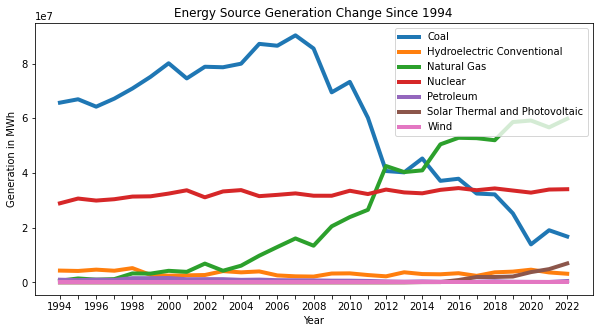


The summary statistics for the regression on ['Coal', 'Hydroelectric Conventional', 'Natural Gas', 'Nuclear', 'Petroleum', 'Solar Thermal and Photovoltaic', 'Wind', 'Core_CPI'] for Industrial consumers are:

Intercept:  4.641425448526136
Coefficients: ('Coal', 1.7538057027637395e-09) ('Hydroelectric Conventional', 4.602701924335941e-08) ('Natural Gas', -4.261227441604979e-08) ('Nuclear', -3.644317657847154e-07) ('Petroleum', -1.747485308969473e-07) ('Solar Thermal and Photovoltaic', -1.4086127548137377e-07) ('Wind', 0.0) ('Core_CPI', 0.100690178183748)

The R² = 77.8475
The Mean Absolute Squared Error = 0.5448
The Mean Squared Error = 0.4726
Root Mean Square Error: 0.6875

Do you want to forecast price? (Y/N): y

Enter coal generation in MWh: 16778383.0
Enter hydro generation in MWh: 3176979.0
Enter natural gas generation in MWh: 59848731.0
Enter nuclear generation in MWh: 34073591.0
Enter petroleum generation in MWh: 517236.0
Enter solar generation in MWh: 6947061.0
Enter wind genera

C:\Users\Samsung\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [19]:
Energy_Price_Impact_Tool()

In [4]:
    # Graphs to implement

    # Create the bar plots
#plt.figure(figsize=(10,5)) 
#plt.plot(combined['US']['Coal'],  label='Renewables', linewidth = '4')
#plt.plot(combined['US']['Wind'],  label='Fossil Fuels', linewidth = '4')
#plt.plot(combined['US']['Nuclear'], label='Nuclear', linewidth = '4')
#ax = plt.gca()   
    # Add x-axis and y-axis labels and a title
#plt.xlabel('Year')
#plt.ylabel('Percent of all Energy Generation')
#plt.title('Energy Share Change')
#n = 3  # Keeps every nth label
#[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    # Add legend
#plt.legend()
    #change chart size
    # Show the chart
#plt.show()

In [5]:
#def montecarlo(df):
#    X = df[['Renewables_pct', 'Fossil_Fuels_pct', 'Nuclear_pct', 'CPI']]#.values
#    y = df['Residential']#.values
#    
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

#    global mlr
#    mlr = LinearRegression()  
#    mlr.fit(X_train, y_train)
#    global y_pred_mlr
#    y_pred_mlr = mlr.predict(X_test)
    
#    meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
#    meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
#    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))

#    return round(mlr.score(X,y)*100, 4), meanAbErr, meanSqErr, rootMeanSqErr

#montecarlo(combined['US'])

#outputs = []
#for x in range(1,101):
#    outputs.append(montecarlo(combined['US']));  

#for x in outputs:
#    rsquare = x[0].mean()
#    MAE = x[1].mean()
#    MSE = x[2].mean()
#    RMSE = x[3].mean()

#print("Intercept: ", mlr.intercept_)
#print("Coefficients:", *list(zip(X, mlr.coef_)))    
#print(f"\nThe R² = {round(rsquare, 4)}")
#print(f"The Mean Absolute Squared Error = {round(MAE,4)}")
#print(f"The MSE = {round(MSE,4)}")

#price_prediction = mlr.predict([[21.29,60.35,18.24,158.9534]])
#print("The forecasted price is", round(*price_prediction, 2))

In [6]:
# Use a for loop to run 100 times and find avg? or just use random state

#X = combined['US'][['Coal','Hydroelectric Conventional','Natural Gas','Nuclear','Petroleum','Solar Thermal and Photovoltaic','Total','Wind']]#.values
#y = combined['US']['Residential']#.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 4)

#mlr = LinearRegression()  
#mlr.fit(X_train, y_train)

#print("Intercept: ", mlr.intercept_)
#print("Coefficients:")
#print(list(zip(X, mlr.coef_)))


#y_pred_mlr= mlr.predict(X_test)
#mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
#mlr_diff.head()

#meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
#meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
#rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
#print('\nR squared: {:.2f}'.format(mlr.score(X,y)*100))
#print('Mean Absolute Error:', meanAbErr)
#print('Mean Square Error:', meanSqErr)
#print('Root Mean Square Error:', rootMeanSqErr)

#price_prediction = mlr.predict([[21, 60, 18, cpi_forecast[-1]]])
#price_prediction

In [7]:
#Working choice option for X's



#def test():
#    independent_vars_selection = str(input("Enter your predictive factor type, P for Percentage of Energy Source, G for Generation in MWh: "))
#    Choice0 = str(input("Would you like to choose your independent variables? (Y/N)"))
#    
#    if independent_vars_selection.upper() == 'P':
#        if Choice0.upper() == 'Y':
#            independent_vars = []
#            ChoiceP1 = input('Would you like to include Renewable Energy? (Y/N):')
#            if ChoiceP1.upper() == 'Y':
#                ChoiceP1 = 'Renewable_pct'
#            #elif ChoiceP1 == 'N':
#            #    ChoiceP1 = 'N'
#            ChoiceP2 = input('Would you like to include Fossil Fuels? (Y/N):')
#            if ChoiceP2.upper() == 'Y':
#                ChoiceP2 = 'Fossil_Fuels_pct'
#            ChoiceP3 = input('Would you like to include Nuclear Energy? (Y/N):')
#            if ChoiceP3.upper() == 'Y':
#                ChoiceP3 = 'Nuclear_pct'
#            ChoiceP4 = input('Would you like to include Pumped Storage Energy? (Y/N):')
#            if ChoiceP4.upper() == 'Y':
#                ChoiceP4 = 'Pumped_Storage_pct'
#            ChoiceP5 = input('Would you like to include the Other Energy Category? (Y/N):')
#            if ChoiceP5.upper() == 'Y':
#                ChoiceP5 = 'Other_pct'
#            pricechoices = [ChoiceP1, ChoiceP2, ChoiceP3, ChoiceP4, ChoiceP5]
#            for x in pricechoices:
#                if x != 'N':
#                    independent_vars.append(x)
#            print(independent_vars)
#        elif Choice0.upper() =='N':
#            independent_vars = ['Renewables_pct', 'Fossil_Fuels_pct', 'Nuclear_pct']

In [8]:
#test()